In [20]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
exp = 'FR1'
poss_subs = df[df.experiment == exp]

In [22]:
# for now, get an example subject's FR data
# subs = ['R1112M','R1163T'] #'R1112M' # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # there's something weird going on in R1001P
# subs = ['R1010J','R1112M'] # original 2
# sess = 2
sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # & (df.session == sess)]
# sub_df = sub_df[1:4]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
18,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,1,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
25,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,0,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
26,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,1,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
37,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,0,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
38,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,1,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
639,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,0,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
640,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,1,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...


## Get raw, 80-120 Hz, and 250-500 Hz eeg and detect ripples!

In [25]:
import mne
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt
%matplotlib inline
from pylab import *
%autoreload

save_values = 1
filter_type = 'hamming'#'hamming'# 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm

IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
psth_start = -IRI # only makes sense to look at period <= IRI
psth_end = 2000 # how long to grab data after recall
ret_length = 30000

desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.

ripple_array = []; ripple_array2 = []; trial_nums = []; trial_nums2 = []
session_ct = 0; channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
for row in sub_df.itertuples():    
    sub = row.subject; session = row.session; exp = row.experiment
    mont = int(row.montage); loc = int(row.localization)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    evs_free_recall = evs[evs.type=='REC_WORD']
    total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
    total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
    # remove events with Inter-Recall Intervals too small. Use psth_start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] 
    kept_recalls = kept_recalls + len(evs_free_recall)
    pairs = reader.load('pairs')
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct) 
    # also let's grab whole retrieval periods for a better baseline of SWRs
    evs_rets = evs[evs.type=='REC_START']
    
    # load eeg
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    # events X electrodes X time
    sr = eeg.samplerate
    if np.mod(sr,1)>0: # if not an integer, there are issues, so skip
        continue
    else:
        sr = int(sr)
        print('Sampling rate: '+str(sr))
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa2 = reader.load_eeg(events=evs_rets, rel_start=0, rel_stop=ret_length, clean=True, scheme=pairs).to_ptsa()
        
    # FIR filter a la Norman et al
    trans_width = 5.
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
    FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=sr, window='hamming',pass_zero='bandstop')
    
    # filter using filter selected above
    if filter_type == 'butter':
        eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
        eeg_rip_band2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
    elif filter_type == 'hamming':
        # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA
        eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
        eeg_rip_band2 = eeg_ptsa2-filtfilt(FIR_bandstop,1.,eeg_ptsa2)
    if sr == 500: # 500 is half the sr so go to 499
        # Vaz used 250 HP, but since I'm at Nyquist of 250, need to drop a bit below to detect anything (249 sees nothing)
        # in fact I dropped to 200 since I wasn't seeing anything at 249 with 500 sr. Seems like a nice, conservative method since I cut off at 180 Hz
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter() 
        eeg_ied_band2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=200., filt_type='highpass',order=2).filter() 
    elif sr >= 1000:    
        # this seems okay since large range far from Nyquist...shold check though
        print('Using 250-499 Hz Butterworth for 1000 Hz. Might want to check iedlogic v. ripplelogic??')
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
        eeg_ied_band2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
    else:
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter()
        eeg_ied_band2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=200., filt_type='highpass',order=2).filter()
    
    eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start])
    _ = eeg_rip_band.apply_hilbert(envelope=True)
    eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start])
    _ = eeg_ied_band.apply_hilbert(envelope=True)
    eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start])   
    
    eeg_rip_band2 = ptsa_to_mne(eeg_rip_band2,[0,ret_length])
    _ = eeg_rip_band2.apply_hilbert(envelope=True)
    eeg_ied_band2 = ptsa_to_mne(eeg_ied_band2,[0,ret_length])
    _ = eeg_ied_band2.apply_hilbert(envelope=True)
    eeg_raw2 = ptsa_to_mne(eeg_ptsa2,[0,ret_length]) 

    HPC_session_ct = 0
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            channel_ct+=1 # total channels from beginning 
            HPC_session_ct+=1 # channel ct for this session
            HPC_names.append(elec_regions[channel])
            sub_names.append(sub)
            sub_sess_names.append(sub+'-'+str(session))
            eeg_rip = eeg_rip_band.get_data()[:,channel,:] # get data from MNE container
            eeg_ied = eeg_ied_band.get_data()[:,channel,:]
            eeg_mne = eeg_raw.get_data()[:,channel,:]
            eeg_rip2 = eeg_rip_band2.get_data()[:,channel,:] # get data from MNE container
            eeg_ied2 = eeg_ied_band2.get_data()[:,channel,:]
            eeg_mne2 = eeg_raw2.get_data()[:,channel,:]            
            
            # select detection algorithm (note that iedlogic is same for both so always run that)
            temp_ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)
            if filter_type == 'butter':
                ripplelogic = temp_ripplelogic 
            elif filter_type == 'hamming':
                ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
            temp_ripplelogic2, iedlogic2 = detectRipplesButter(eeg_rip2,eeg_ied2,eeg_mne2,sr)
            if filter_type == 'butter':
                ripplelogic2 = temp_ripplelogic2
            elif filter_type == 'hamming':
                ripplelogic2 = detectRipplesHamming(eeg_rip2,trans_width,sr,iedlogic2)

            # have to make a decision on upsampling v. downsampling since there are diff. sampling rates
            if sr>desired_sample_rate: # downsampling here for anything greater than 500...will be issues if SR not divisible
                # but can fix that in the future if necessary (maybe can FFT resample?)
                ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
                iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate)
                ripplelogic2 = downsampleBinary(ripplelogic2,sr/desired_sample_rate)
                iedlogic2 = downsampleBinary(iedlogic2,sr/desired_sample_rate)
            ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
            ripple_array2 = superVstack(ripple_array2,ripplelogic2) # append across electrodes            
            print('Cumulative array size: ')
            print(ripple_array.shape)
            trial_nums = np.append(trial_nums,ripplelogic.shape[0])
            trial_nums2 = np.append(trial_nums2,ripplelogic2.shape[0])
    electrodes_per_session = np.append(electrodes_per_session,HPC_session_ct)
    session_ct+=1   

fn = os.path.join('/home1/john/SWR/',
    'SWR_array_from-'+str(session_ct)+'_sessions_in-'+str(len(np.unique(sub_names)))+'subjects_'+filter_type+'.p')            
with open(fn,'wb') as f:
    pickle.dump({'ripple_array':ripple_array, 'session_ct':session_ct,
                'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                'channel_ct':channel_ct, 'ripple_array2':ripple_array2,
                'trial_nums':trial_nums, 'trial_nums2':trial_nums2}, f)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1002P/tal/R1002P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1002P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
84 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
84 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
84 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(84, 2000)
Cumulative array size: 
(168, 2000)
Cumulative array size: 
(252, 2000)
Cumulative array size: 
(336, 2000)
Cumulative array size: 
(420, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1002P/tal/R1002P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1002P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(475, 2000)
Cumulative array size: 
(530, 2000)
Cumulative array size: 
(585, 2000)
Cumulative array size: 
(640, 2000)
Cumulative array size: 
(695, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1003P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1003P/tal/R1003P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1003P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1003P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
90 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
90 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
90 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(785, 2000)
Cumulative array size: 
(875, 2000)
Cumulative array size: 
(965, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1003P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1003P/tal/R1003P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1003P/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1003P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
95 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
95 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
95 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(1060, 2000)
Cumulative array size: 
(1155, 2000)
Cumulative array size: 
(1250, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1006P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1006P/tal/R1006P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1006P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1006P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
83 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
83 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
83 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(1333, 2000)
Cumulative array size: 
(1416, 2000)
Cumulative array size: 
(1499, 2000)
Cumulative array size: 
(1582, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1006P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1006P/tal/R1006P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1006P/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1006P/eeg.noreref/R1006P_12Feb15_1126.params.txt
/data/eeg/R1006P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFound

Sampling rate: 1000
Using 250-499 Hz Butterworth for 1000 Hz. Might want to check iedlogic v. ripplelogic??
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(1647, 2000)
Cumulative array size: 
(1712, 2000)
Cumulative array size: 
(1777, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1010J/tal/R1010J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1010J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 1000
Using 250-499 Hz Butterworth for 1000 Hz. Might want to check iedlogic v. ripplelogic??
61 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
61 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
61 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(1838, 2000)
Cumulative array size: 
(1899, 2000)
Cumulative array size: 
(1960, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

Sampling rate: 500
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(1992, 2000)
Cumulative array size: 
(2024, 2000)
Cumulative array size: 
(2056, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_1_03Dec15_0938.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

Sampling rate: 500
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(2096, 2000)
Cumulative array size: 
(2136, 2000)
Cumulative array size: 
(2176, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_2_05Dec15_0921.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

Sampling rate: 500
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
16 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
16 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
16 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(2188, 2000)
Cumulative array size: 
(2200, 2000)
Cumulative array size: 
(2212, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1163T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1163T/tal/R1163T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1163T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1163T/eeg.noreref/R1163T_FR1_0_14Apr16_1429.params.txt
/data/eeg/R1163T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

Sampling rate: 1000
Using 250-499 Hz Butterworth for 1000 Hz. Might want to check iedlogic v. ripplelogic??
20 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
20 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
20 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(2232, 2000)
Cumulative array size: 
(2252, 2000)
Cumulative array size: 
(2272, 2000)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1163T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1163T/tal/R1163T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1163T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1163T/eeg.noreref/R1163T_FR1_1_15Apr16_1606.params.txt
/data/eeg/R1163T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

Sampling rate: 1000
Using 250-499 Hz Butterworth for 1000 Hz. Might want to check iedlogic v. ripplelogic??
37 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
37 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
37 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Cumulative array size: 
(2309, 2000)
Cumulative array size: 
(2346, 2000)
Cumulative array size: 
(2383, 2000)


## outputs from load:

In [28]:
print('Total electrodes loaded: '+str(channel_ct))
print('from '+str(session_ct)+' sessions from '+str(len(np.unique(sub_names)))+' subjects')
print(HPC_names)
print(sub_sess_names)

Total electrodes loaded: 41
from 12 sessions from 6 subjects
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'right sub', 'right dg', 'right dg', 'right ca1', 'left ca1', 'left dg', 'left ca1', 'left ca1', 'left dg', 'left ca1', 'right dg', 'right dg', 'right ca1', 'right dg', 'right dg', 'right ca1', 'right dg', 'right dg', 'right ca1', 'right ca1', 'left ca1', 'left ca1', 'right ca1', 'left ca1', 'left ca1']
['R1002P-0', 'R1002P-0', 'R1002P-0', 'R1002P-0', 'R1002P-0', 'R1002P-1', 'R1002P-1', 'R1002P-1', 'R1002P-1', 'R1002P-1', 'R1003P-0', 'R1003P-0', 'R1003P-0', 'R1003P-1', 'R1003P-1', 'R1003P-1', 'R1006P-0', 'R1006P-0', 'R1006P-0', 'R1006P-0', 'R1010J-0', 'R1010J-0', 'R1010J-0', 'R1010J-1', 'R1010J-1', 'R1010J-1', 'R1112M-0', 'R1112M-0', 'R1112M-0', 'R1112M-1', 'R1112M-1', 'R1112M-1', 'R1112M-2', 'R1112M-2', 'R1112M-2', 'R1163T-0', 'R

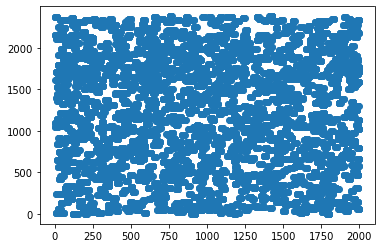

In [242]:
# Let's plot the change in SWRs by region
pre_time = 1000 # how long to look for ripples
post_time = 1000
for s in range(len(HPC_names)):
    # first, get the change in SWRs from before until after recall

Total FR events: 1068
Kept FR events: 714
(2383, 2000)


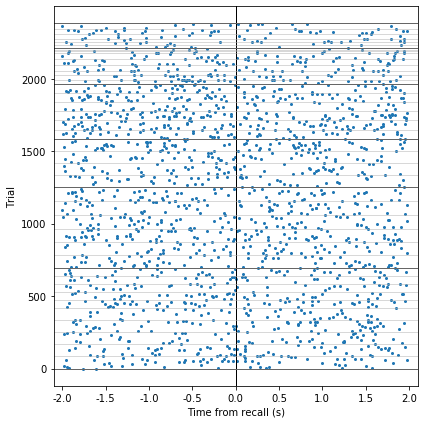

In [243]:
## for the raster and PSTH binarize the data by using the start indices of the ripple
%autoreload
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = (1000/sr)
start_array = np.zeros((ripple_array.shape))
end_array = np.zeros((ripple_array.shape))
num_trials = ripple_array.shape[0]
for trial in range(num_trials):
    ripplelogictrial = ripple_array[trial]
    starts,ends = getLogicalChunks(ripplelogictrial)
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[starts] = 1
    start_array[trial] = temp_row # time when each SWR starts
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[ends] = 1
    end_array[trial] = temp_row

# plot raster
subplots(1,1,figsize=(6,6))   
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
tight_layout()
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
last_sub = sub_names[0]
for s in range(1,len(trial_nums)):
    if sub_names[s] != last_sub:
        # plot dark gray line between subjects
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
        last_sub = sub_names[s]
    else: # plot light gray line between sessions
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
print('Total FR events: '+str(total_recalls))
print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);

In [244]:
# make a PSTH based on start times of SWRs
binsize = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?

PSTH,bin_centers = fullPSTH(start_array,binsize,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
               bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
boot_SD = np.std(boot_samples,0)

# create a resampling surrogate to probe chance and do cluster stats
# the surrogate is samples number of PSTHs where the num of ripples kept constant
# in each trial but the times were randomly shifted in those trials
nbins = int(np.ceil(start_array.shape[1]/binsize))
shuffledRate = np.zeros((nbins,samples))
realRate = PSTH
samples = 100
num_trials = start_array.shape[0]
time_length = start_array.shape[1]
shuffledRate = []
for i in range(samples):
    # get list of trials with replacement and the number of ripples within them
    rip_ct = np.sum(start_array,1)
    permdata = np.zeros(np.shape(start_array))
    for trial in range(num_trials):
        if rip_ct[trial]>0:
            rand_times = randint(0,time_length,int(rip_ct[trial])) # randomize rip times w/in each trial
            permdata[trial,rand_times] = 1 # so each trial always has same # of SWRs
    permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,psth_start)        
    shuffledRate = superVstack(shuffledRate,permPSTH) # sample X bins
shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
mean_shuffled_rate = np.mean(shuffledRate)
shuffled_std = np.std(shuffledRate)

# find significant clusters
cluster_thresh = 1.96
# get lower and upper 1.96 SD thresholds
thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
max_clusts = []
for i in range(samples):
    temp = (shuffledRate[i]<thresh[0]) | (shuffledRate[i]>thresh[1]) 
    starts,ends = getLogicalChunks(temp)
    if len(starts)>0:
        temp_clust = (np.array(ends)-np.array(starts))+1 # length of each cluster
        max_clusts.append(np.max(temp_clust)) # longest cluster
    else: max_clusts.append(0)
# actual data
real_thresh_crosses = (realRate<thresh[0]) | (realRate>thresh[1])
starts,ends = getLogicalChunks(real_thresh_crosses)
real_clust = (np.array(ends)-np.array(starts))+1;
bin_centers

array([-1950., -1850., -1750., -1650., -1550., -1450., -1350., -1250.,
       -1150., -1050.,  -950.,  -850.,  -750.,  -650.,  -550.,  -450.,
        -350.,  -250.,  -150.,   -50.,    50.,   150.,   250.,   350.,
         450.,   550.,   650.,   750.,   850.,   950.,  1050.,  1150.,
        1250.,  1350.,  1450.,  1550.,  1650.,  1750.,  1850.,  1950.])

In [247]:
real_clust
real_thresh_crosses

array([], dtype=float64)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

IndexError: list index out of range

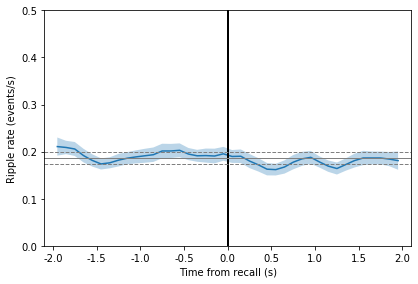

In [248]:
sig_mask = np.zeros(len(temp)) # get locations of significant clusters
clusterPval = []
sig_clust_ranges = []
if sum(real_thresh_crosses)>0:
    real_crossing_starts,_ = getLogicalChunks(real_thresh_crosses) # number of actual crosses is starts
    for k in range(len(real_crossing_starts)): 
        clusterPval.append( (np.sum(max_clusts>real_clust[k])+1) / (samples+1))
        if clusterPval[k]<0.05:
            sig_mask[starts[k]:ends[k]+1]=1
    max_cluster_actual_data = np.max(real_clust)
    # convert significant clsuters to bins
    clust_start,clust_end = getLogicalChunks(sig_mask)
    for cl in range(len(clust_start)):
        sig_bins = bin_centers[clust_start[cl]:clust_end[cl]+1] # get sig. bins and create xvalues for a line
        sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr,PSTH)
fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
# bootstrap SE using random sample with replacement

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ax.set_ylim(0,0.5)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=2,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
plot(x_width,list(mean_shuffled_rate*np.ones(2)),linewidth=1,color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate+shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate-shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
if len(sig_clust_ranges)>0:
    for cl in range(len(sig_clust_ranges)):
        plot(sig_clust_ranges[cl],[0.45,0.45],color=(1,0.7,0.23),linewidth=3)
        print('Cluster p-value: '+str(clusterPval[cl]))
else: print('Largest cluster p-value is: '+str(clusterPval[0]))
a=1;

In [246]:
sig_clust_ranges
clusterPval
xr

[[-1400.0, -900.0], [-600.0, -200.0], [100.0, 700.0]]

[]

array([-1950., -1850., -1750., -1650., -1550., -1450., -1350., -1250.,
       -1150., -1050.,  -950.,  -850.,  -750.,  -650.,  -550.,  -450.,
        -350.,  -250.,  -150.,   -50.,    50.,   150.,   250.,   350.,
         450.,   550.,   650.,   750.,   850.,   950.,  1050.,  1150.,
        1250.,  1350.,  1450.,  1550.,  1650.,  1750.,  1850.,  1950.])

In [196]:
trial_nums
trial_nums[0] # if looking at first session from first subject this many trials
ripple_array.shape # all trials
start_array.shape
eeg.shape
evs_free_recall.shape
electrodes_per_session
np.sum(trial_nums[:2])

array([65., 65., 65., 61., 61., 61., 32., 32., 32., 40., 40., 40., 12.,
       12., 12.])

65.0

(630, 2000)

(630, 2000)

(65, 170, 3975)

(65, 21)

array([3., 3., 3., 3., 3.])

130.0

In [212]:
np.arange(0,post_rip-pre_rip+1,post_rip/4)
np.arange(pre_rip,post_rip+1,post_rip/2)

array([   0.,  125.,  250.,  375.,  500.,  625.,  750.,  875., 1000.])

array([-500., -250.,    0.,  250.,  500.])

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1010J/tal/R1010J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1010J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-

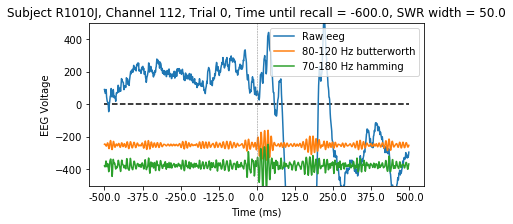

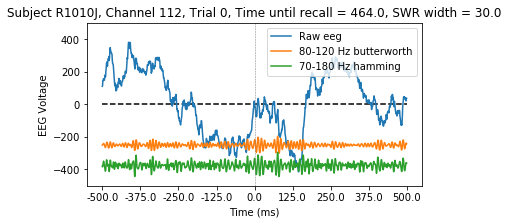

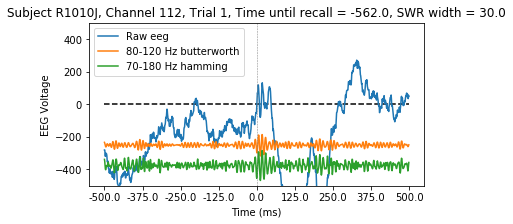

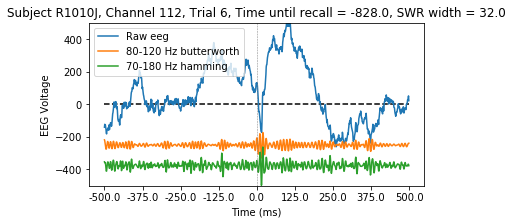

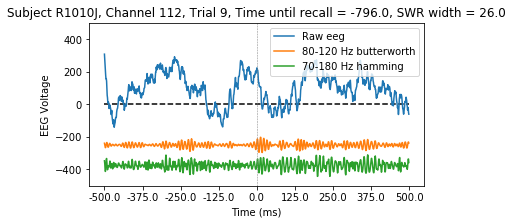

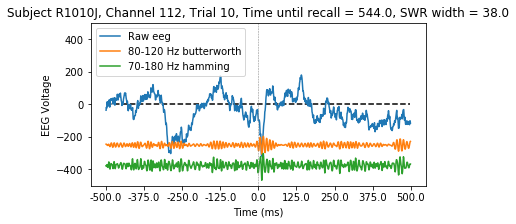

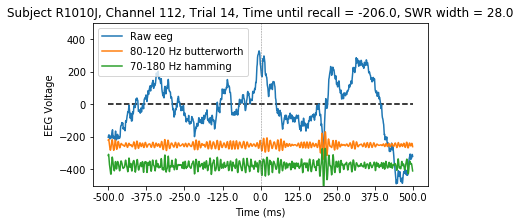

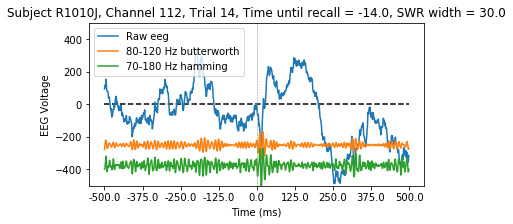

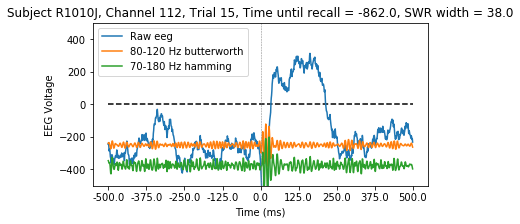

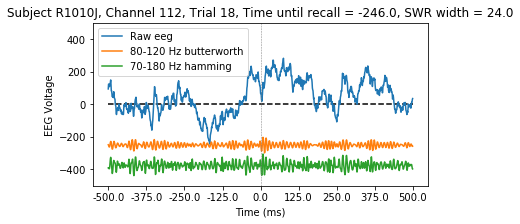

In [213]:
# let's look at some of these SWR events! 

# Need to run top eeg load first to get start_array and sr.
# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 10 # note: will skip trials with no ripples

desired_sample_rate = 500.
desired_sr_factor = 1000/desired_sample_rate # even if SR is >500 for eeg the desired rate for the ripple arrays is set to 500
trans_width = 5.

# bb,aa = butter(2,[70/250,180/250],btype='band') # Butterworth test filter

temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500

ymin = -500 #np.min(stim_eeg[trial,:])
ymax = 500 #np.max(stim_eeg[trial,:])
display_mult = 2 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
    sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
    eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(len(evs_free_recall)): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and print_ct<trials_to_print:
                    if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*desired_sr_factor)[0] # convert to ms
                        rip_lengths = ((desired_sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple 
                            rip_time = rip_times[rip]
                            rip_length = rip_lengths[rip]
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_vaz = eeg_vaz[trial_ct,channel,int((rip_time+pre_rip)/sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_norman = eeg_norman[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):
                                                             int((rip_time+post_rip)/sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
                                plt.plot(xr,display_mult*filt_eeg_vaz+y_offset)
                                plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','80-120 Hz butterworth','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/4))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

### rip_lengths[0]

In [89]:
## NEVERMIND. Do it based on ISI of recall times, NOT ripple times. That's actually what Norman et al did.
# # Now that we have a start_array with all ripples, need to check ISIs to make sure
# # we're not double-dipping on recall events. For example, if two recall events
# # are only 500 ms apart, we don't want to put the same ripple in the PSTH twice just 500 ms apart
# # remove duplicate ripples < this interripple interval (IRI) time.
# IRI_thresh = abs(start) # Setting to start (PSTH beginning time) makes sense for PSTH
# ripple_idxs = np.where(ripple_mstime_array)
# ripple_abs_times = ripple_mstime_array[ripple_idxs]
# IRIs = np.diff(ripple_abs_times) # inter-ripple intervals
# 
# # this looks at current IRI and cumulative IRIs and eliminates everything but first one
# for rip in range(len(IRIs)): # for each ripple, check if next ripples are within IRI_thresh
#     if IRIs[rip]<=IRI_thresh:
#         # find how many into future are <=IRI_thresh
#         next_rip = 1
#         while np.sum(IRIs[rip:rip+next_rip])<=IRI_thresh:            
#             next_rip+=1
#             if (rip+next_rip)>=len(IRIs):
#                 break
#         # now you know how many ripples to remove
#         IRIs[rip:rip+next_rip-1] = Inf # so it won't be caught again in next step of for loop
#          # +1 below because used diff so always removing ripples after 1st
#         start_array[ripple_idxs[0][rip+1:rip+1+next_rip],ripple_idxs[1][rip+1:rip+1+next_rip]] = 0
#         # note: end_array can be left alone, since it's only indexed after finding a ripple from start_array

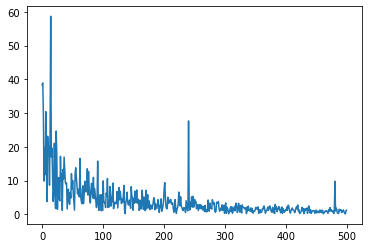

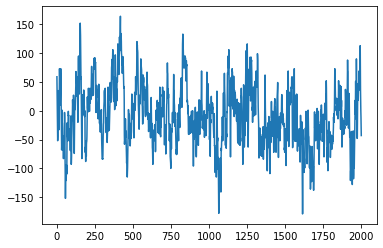

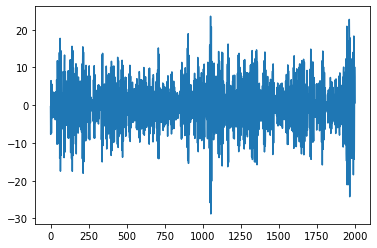

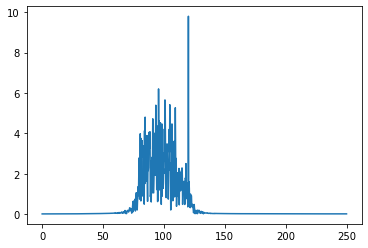

In [482]:
# example fft plot from https://intellipaat.com/community/32125/plotting-a-fast-fourier-transform-in-python
from scipy import fft 

N = 1000 # Number of samplepoints 
T = 1.0 / N # sample spacing 
x = np.linspace(0.0, N*T, N) 

# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = temp
filt80120 = temp.filtered([80,120],order=4,filt_type='bandpass')

yf = fft(y) 
xf = np.linspace(0.0, N/2, N/2) 
fig,ax = plt.subplots() 
ax.plot(xf, 2.0/N * np.abs(yf[:N//2])) 
plt.show()

plt.plot(y)
plt.show()
plt.plot(z)
plt.show()

fft_filt80120 = fft(filt80120)
NN = len(filt80120)
xff = np.linspace(0,NN/8,NN/2) # I think this is 4000 ms/500 SR to get 8
plt.plot(xff,8/NN*np.abs(fft_filt80120[:NN//2]))

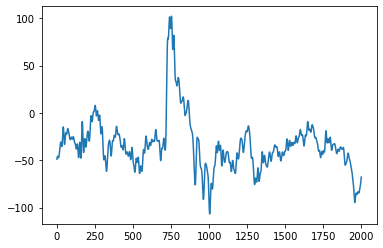

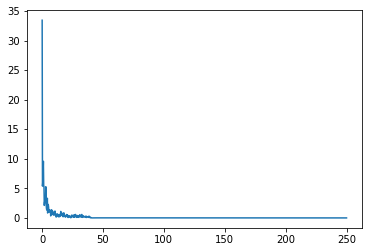

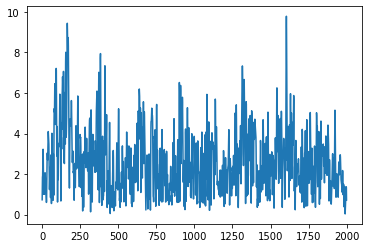

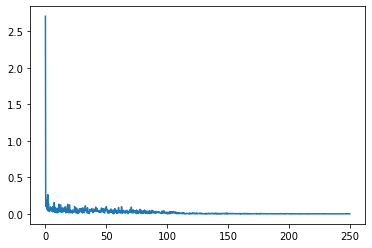

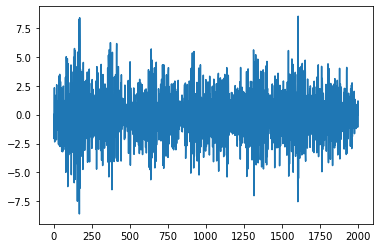

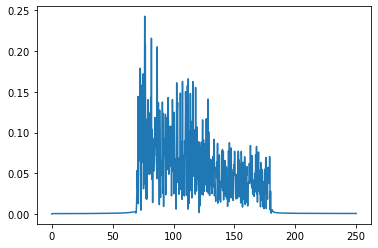

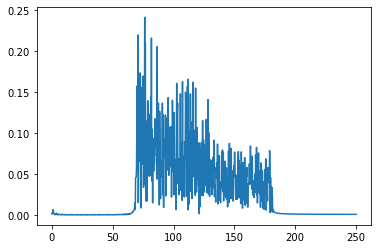

In [126]:
## Example implementations of various filters being used

from scipy.signal import kaiserord,firwin
from scipy import fft

FIR_bandpass = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming')

NN = eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(4000/sr),NN/2) # 4000 ms of data/500 Hz sampling

## WHAT IS WRONG WITH EEG_RIP?? Nothing! Just hilbert+rectification ruins the bandpass in the FFT

# plot FFT of kaiser 40 hz lowpass
temp_rip = eeg_ptsa[0][0]-8650+1500
filt_temp_rip = filtfilt(kaiser_40lp_filter,1.,temp_rip)
plt.plot(filt_temp_rip); plt.show()
plt.plot(xr,normFFT(filt_temp_rip)); plt.show()

# plot FFT of rectified ripple eeg
temp_rip_band = eeg_rip_band.get_data()[0,0,:]
plt.plot(temp_rip_band); plt.show()
plt.plot(xr,normFFT(temp_rip_band)); plt.show()

# take single trial and filter using Norman FIR filter
temp_eeg = eeg_ptsa[0][0]+8650 # baseline subtracted trial of eeg
temp = filtfilt(FIR_bandpass,1.,temp_eeg)
plt.plot(temp); plt.show()
plt.plot(xr,normFFT(temp)); plt.show();
plt.plot(xr,normFFT(temp_eeg-filtfilt(FIR_bandstop,1.,temp_eeg))); plt.show()